In [1]:
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from scipy.stats import ttest_ind

In [2]:
dataset = "WorkersCompensation"
subset_col = "Gender"
subset_value = 'M'
model = 'tree'
metric= 'rmse'
results_df = pd.read_csv(f"results/{dataset}/{subset_col}.csv")

In [12]:
def soak_plot_one_model_downsample_split(results_df, subset_value, model, metric="rmse", figsize=(6, 2.5)):

    def pval(cat1, cat2):
        x = df.loc[df["category"] == cat1, metric]
        y = df.loc[df["category"] == cat2, metric]
        t_stat, p = ttest_ind(x, y, equal_var=False)
        return p

    df = results_df[
        (results_df["subset"] == subset_value) &
        (results_df["model"] == model)
    ].copy()
    df["category"] = (
        df["category"]
        + "."
        + df["downsample"].map({False: "full", True: "ds"})
    )

    cats = set(df["category"].unique())
    sorted_cats_full = ["other.full", "same.full", "all.full"]
    sorted_cats_ds = ["other.ds", "same.full", "all.ds"]
    if "same.ds" in cats:
        sorted_cats_ds = ["other.full", "same.ds", "all.ds"]

    dfs = [None, None]
    for i, sorted_cats in enumerate([sorted_cats_full, sorted_cats_ds]):
        # base summary
        summary = (
            df.groupby("category", observed=False)
            .agg(
                mean=(metric, "mean"),
                std=(metric, "std"),
                train_size=("train_size", "min"),
            )
            .reindex(sorted_cats)
            .reset_index())

        combined = pd.DataFrame({
            "category": [f"{sorted_cats[0]}-{sorted_cats[1]}", f"{sorted_cats[2]}-{sorted_cats[1]}"],
            "mean": [
                (summary.iloc[0]['mean'] + summary.iloc[1]['mean']) / 2,
                (summary.iloc[2]['mean'] + summary.iloc[1]['mean']) / 2
            ],
            "std": [
                abs(summary.iloc[0]['mean'] - summary.iloc[1]['mean']) / 2,
                abs(summary.iloc[2]['mean'] - summary.iloc[1]['mean']) / 2
            ],
            "p_value": [
                pval(sorted_cats[0], sorted_cats[1]),
                pval(sorted_cats[2], sorted_cats[1]),
            ]
        })

        n = len(sorted_cats) + len(combined['category'].to_list())
        category_order = [None] * n
        category_order[::2] = sorted_cats
        category_order[1::2] = combined['category'].to_list()

        combined["train_size"] = np.nan
        summary["p_value"] = np.nan

        final = pd.concat([summary, combined], ignore_index=True)
        final = (
            final.assign(category=lambda x: pd.Categorical(x["category"], category_order, ordered=True))
            .sort_values("category")
            .reset_index(drop=True)
        )
        final["category"] = final.apply(
            lambda row: f"{row['category']}.{int(row['train_size'])}" 
            if pd.notnull(row['train_size']) 
            else row['category'], 
            axis=1
        )
        dfs[i] = final

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    for idx, ax in enumerate(axes):
        df = dfs[idx]
        category_order = df['category'].unique().tolist()
        y_pos = {cat: i for i, cat in enumerate(category_order)}
        for i, row in df.iterrows():
            y = y_pos[row["category"]]
            mean = row["mean"]
            sd = row["std"]
            color = 'black' if i % 2 == 0 else 'grey'
            text = f"{mean:.5f} ± {sd:.5f}" if i % 2 == 0 else f"P = {row['p_value']:.4f}"
            marker_size = 4 if i % 2 == 0 else 0
            ax.errorbar(mean, y, xerr=sd, fmt="o", color=color, markersize=marker_size)
            ax.text(mean, y + 0.15, text, ha="center", va="bottom", fontsize=8)

        # y-axis formatting
        ax.set_yticks([y_pos[c] for c in category_order])
        ax.set_yticklabels(category_order, fontsize=9)
        ax.set_ylim(-0.5, len(category_order) - 0.2)

        # labels & title
        ax.set_title("full" if idx==0 else "downsample", fontsize=10)
        ax.grid(alpha=0.5)
        ax.xaxis.set_major_formatter(FormatStrFormatter("%.3f"))
        ax.tick_params(axis='x', labelsize=9)

    fig.supxlabel(f"{metric.upper()} (mean ± 2sd) | subset: {subset_value} | model: {model} | {set(results_df['fold_id']).__len__()} test folds | {len(set(results_df['seed_id']))-1} random seeds for downsample", fontsize=11)
    fig.tight_layout()
    plt.close(fig)
    return fig

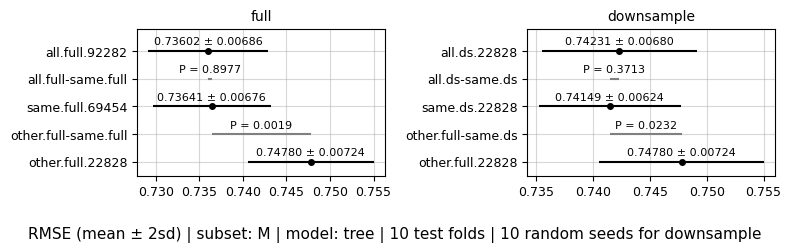

In [15]:
soak_plot_one_model_downsample_split(results_df, subset_value, model, metric="rmse", figsize=(8, 2.5))

: 

In [ ]:
# # calculate p-values for combined categories
# def pval(cat1, cat2):
#     x = df.loc[df["category"] == cat1, metric]
#     y = df.loc[df["category"] == cat2, metric]
#     t_stat, p = ttest_ind(x, y, equal_var=False)  # Welch's t-test
#     return p

# df = results_df[
#     (results_df["subset"] == subset_value) &
#     (results_df["model"] == model)
# ].copy()
# df["category"] = (
#     df["category"]
#     + "."
#     + df["downsample"].map({False: "full", True: "ds"})
# )

# cats = set(df["category"].unique())
# sorted_cats_full = ["other.full", "same.full", "all.full"]
# sorted_cats_ds = ["other.ds", "same.full", "all.ds"]
# if "same.ds" in cats:
#     sorted_cats_ds = ["other.full", "same.ds", "all.ds"]

# dfs = [None, None]
# for i, sorted_cats in enumerate([sorted_cats_full, sorted_cats_ds]):
#     # base summary
#     summary = (
#         df.groupby("category", observed=False)
#         .agg(
#             mean=(metric, "mean"),
#             std=(metric, "std"),
#             train_size=("train_size", "min"),
#         )
#         .reindex(sorted_cats)
#         .reset_index())

#     combined = pd.DataFrame({
#         "category": [f"{sorted_cats[0]}-{sorted_cats[1]}", f"{sorted_cats[2]}-{sorted_cats[1]}"],
#         "mean": [
#             (summary.iloc[0]['mean'] + summary.iloc[1]['mean']) / 2,
#             (summary.iloc[2]['mean'] + summary.iloc[1]['mean']) / 2
#         ],
#         "std": [
#             abs(summary.iloc[0]['mean'] - summary.iloc[1]['mean']) / 2,
#             abs(summary.iloc[2]['mean'] - summary.iloc[1]['mean']) / 2
#         ],
#         "p_value": [
#             pval(sorted_cats[0], sorted_cats[1]),
#             pval(sorted_cats[2], sorted_cats[1]),
#         ]
#     })

#     n = len(sorted_cats) + len(combined['category'].to_list())
#     category_order = [None] * n
#     category_order[::2] = sorted_cats
#     category_order[1::2] = combined['category'].to_list()

#     combined["train_size"] = np.nan
#     summary["p_value"] = np.nan

#     final = pd.concat([summary, combined], ignore_index=True)
#     final = (
#         final.assign(category=lambda x: pd.Categorical(x["category"], category_order, ordered=True))
#         .sort_values("category")
#         .reset_index(drop=True)
#     )
#     final["category"] = final.apply(
#         lambda row: f"{row['category']}.{int(row['train_size'])}" 
#         if pd.notnull(row['train_size']) 
#         else row['category'], 
#         axis=1
#     )
#     dfs[i] = final

: 

In [ ]:
# category_order = dfs[0]['category'].to_list()

# fig, ax = plt.subplots(figsize=(5, 3))

# y_pos = {cat: i for i, cat in enumerate(category_order)}
# for i, row in dfs[0].iterrows():
#     y = y_pos[row["category"]]
#     mean = row["mean"]
#     sd = row["std"]
#     color = 'black' if i % 2 == 0 else 'grey'
#     text = f"{mean:.5f} ± {sd:.5f}" if i % 2 == 0 else f"P = {row['p_value']:.4f}"
#     marker_size = 4 if i % 2 == 0 else 0
#     ax.errorbar(mean, y, xerr=sd, fmt="o", color=color, markersize=marker_size)
#     ax.text(mean, y + 0.15, text, ha="center", va="bottom", fontsize=8)

# # y-axis formatting
# ax.set_yticks([y_pos[c] for c in category_order])
# ax.set_yticklabels(category_order, fontsize=9)
# ax.set_ylim(-0.5, len(category_order) - 0.2)

# # labels & title
# ax.set_xlabel(metric.upper(), fontsize=8)
# ax.grid(alpha=0.5)
# ax.xaxis.set_major_formatter(FormatStrFormatter("%.3f"))
# ax.tick_params(axis='x', labelsize=9)
# fig.tight_layout()

: 

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.ticker import FormatStrFormatter

# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# for idx, ax in enumerate(axes):
#     df = dfs[idx]
#     category_order = df['category'].unique().tolist()
#     y_pos = {cat: i for i, cat in enumerate(category_order)}
#     for i, row in df.iterrows():
#         y = y_pos[row["category"]]
#         mean = row["mean"]
#         sd = row["std"]
#         color = 'black' if i % 2 == 0 else 'grey'
#         text = f"{mean:.5f} ± {sd:.5f}" if i % 2 == 0 else f"P = {row['p_value']:.4f}"
#         marker_size = 4 if i % 2 == 0 else 0
#         ax.errorbar(mean, y, xerr=sd, fmt="o", color=color, markersize=marker_size)
#         ax.text(mean, y + 0.15, text, ha="center", va="bottom", fontsize=8)

#     # y-axis formatting
#     ax.set_yticks([y_pos[c] for c in category_order])
#     ax.set_yticklabels(category_order, fontsize=9)
#     ax.set_ylim(-0.5, len(category_order) - 0.2)

#     # labels & title
#     ax.set_title("full" if idx==0 else "downsample", fontsize=10)
#     ax.grid(alpha=0.5)
#     ax.xaxis.set_major_formatter(FormatStrFormatter("%.3f"))
#     ax.tick_params(axis='x', labelsize=9)

# fig.supxlabel(f"{metric.upper()} (mean ± 2sd) | subset: {subset_value} | model: {model} | {set(results_df['fold_id']).__len__()} folds", fontsize=12)
# fig.tight_layout()

: 

: 

: 